In [1]:
from os import listdir, makedirs
from os.path import isfile, isdir, join
import cv2  
import copy
import json
import numpy as np

def open_temp_db():
    db = []
    dorsal_acupunctures = {'양계':'yanggye', '양지':'yangji', '외관':'oegwan', '양곡':'yanggok', 
                            '합곡':'hapgok', '중저':'jungjer', '삼간':'samgan', '이간':'egan',
                            '액문':'ekmoon','상양':'sangyang','중층':'jungcheung','소충':'sochung',
                            '소택':'sotack','관충':'gwanchung', '휴게': 'hugye'}
    palmar_acupunctures = {'신문':'shinmoon','대릉':'daereung','태연':'taeyeon','어제':'urjae',
                            '소부':'sobu','노궁':'nogung','소상':'sosang'}

    db.append(dorsal_acupunctures)
    db.append(palmar_acupunctures)
    return db

def make_path_tuple(acupuncture_info, changed_hands_path):
    path = []
    for _ in changed_hands_path:
        for f in listdir(_):
            hand_pos = (_.split('/')[2]).strip(f'{acupuncture_info}_')
            path.append((join(_,f), hand_pos))
    return path

def is_acupuncture(ac, db):
    flag = False
    for _ in db:
        if ac in _:
            flag = True
            ac = _.get(ac)
            return ac
    if not flag:
        print("Can't find acupuncture info")
        exit()

def open_json_file(file_path):
    if isfile(file_path):
        with open(file_path, 'r') as json_file:
            json_data = json.load(json_file)
        return json_data
    else:
        print("json file doesn't exist")
        exit()        

def save_json_file(json_data, json_file):
    with open(json_file, 'w') as outfile:
        json.dump(json_data, outfile, indent='\t')

def rotate_bound(image, theta):
    # grab the dimensions of the image and then determine the
    # centre
    (h, w) = image.shape[:2]
    (cX, cY) = (w // 2, h // 2)

    # grab the rotation matrix (applying the negative of the
    # angle to rotate clockwise), then grab the sine and cosine
    # (i.e., the rotation components of the matrix)
    M = cv2.getRotationMatrix2D((cX, cY), theta, 1.0)
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])

    # compute the new bounding dimensions of the image
    nW = int((h * sin) + (w * cos))
    nH = int((h * cos) + (w * sin))

    # adjust the rotation matrix to take into account translation
    M[0, 2] += (nW / 2) - cX
    M[1, 2] += (nH / 2) - cY

    # perform the actual rotation and return the image
    return cv2.warpAffine(image, M, (nW, nH), borderMode=cv2.BORDER_TRANSPARENT)

def rotate_box(coord, cx, cy, h, w, theta):
    
    # opencv calculates standard transformation matrix
    M = cv2.getRotationMatrix2D((cx, cy), theta, 1.0)
    
    # Grab  the rotation components of the matrix)
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])
    
    # compute the new bounding dimensions of the image
    nW = int((h * sin) + (w * cos))
    nH = int((h * cos) + (w * sin))
    
    # adjust the rotation matrix to take into account translation
    M[0, 2] += (nW / 2) - cx
    M[1, 2] += (nH / 2) - cy
    
    # Prepare the vector to be transformed
    v = [coord[0], coord[1],1]
    
    # Perform the actual rotation and return the image
    calculated = np.dot(M,v)
    new_bb = (calculated[0], calculated[1])
    
    return new_bb
          
def translate_image(images_info, json_data, xmove):

    save_directory = f'./{acupuncture_info}/_translated'
    if not(isdir(save_directory)):
        makedirs(save_directory)

    for i in range(0, len(images_info)):
        img_path = images_info[i][0]
        img_hand_pos = images_info[i][1]
        img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
        img_id = ((img_path.split('/')[-1]).split('_')[-1]).split('.')[0]
        rows,cols = img.shape[:2]

        # translate x-axis and y-axis of the image
        M = np.float32([[1,0,xmove],[0,1,0]])
        dst = cv2.warpAffine(img, M, (cols,rows))
        
        if xmove > 0:
            for row in range(len(dst)):
                for col in range(xmove):
                    if np.array_equal(dst[row,col], np.array([0,0,0])):
                        dst[row,col] = np.array([255,255,255])
        else:
            for row in range(len(dst)):
                for col in range(len(dst[row])-1,len(dst[row])+xmove-1,-1):
                    if np.array_equal(dst[row,col], np.array([0,0,0])):
                        dst[row,col] = np.array([255,255,255])
            j

        acupuncture_id = f"{acupuncture_info}_{img_id}"
        x, y, xy = json_data[acupuncture_id][1].values()
        
        acupuncture_new_id = acupuncture_id + f'_tr{xmove}' if xmove >= 0 else acupuncture_id + f'_tr{xmove}'
        
        json_data[acupuncture_new_id] = list()
        json_data[acupuncture_new_id].append({
            "acup_info": f"{acupuncture_info}",
            "hand_pos": f"{img_hand_pos}",
            "acup_size": f"{acupuncture_size}"
        })
        json_data[acupuncture_new_id].append({
            "acup_coord_x": x + xmove,
            "acup_coord_y": y,
            "acup_coord": (x + xmove, y)
        })
        
        cv2.imwrite('./{0}/{1}.png'.format(save_directory, acupuncture_new_id), dst)
        

    save_json_file(json_data)

def scaling_image(images_info, json_data, dim):

    save_directory = f'./{acupuncture_info}/_scaled'
    if not(isdir(save_directory)):
        makedirs(save_directory)
    
    x_offset = [0, 80, 160, 240]
    # x_offset = [0, 20, 40, 60, 80, 100, 120, 140, 160, 180]

    for i in range(0, len(images_info)):
        img_path = images_info[i][0]
        img_hand_pos = images_info[i][1]
        
        img = cv2.resize(cv2.imread(img_path, cv2.IMREAD_UNCHANGED), dsize=(dim,dim))
        img_id = ((img_path.split('/')[-1]).split('_')[-1]).split('.')[0]
        height, width = img.shape[:2]
        
        blank_image = np.zeros((700,700,3), np.uint8)
        blank_image[:,:] = (255,255,255)
        l_img = blank_image.copy()
        for xmove in x_offset:
            if dim + xmove < 700:
                for row in range(len(img)):
                    for col in range(len(img)):
                        l_img[row, col+xmove] = img[row, col]
                        
                acupuncture_id = f"{acupuncture_info}_{img_id}"
                acupuncture_new_id = acupuncture_id + f'_sc{dim}_tr{xmove}'
                x, y, xy = json_data[acupuncture_id][1].values()
                new_x, new_y = x * dim / 700 + xmove, y * dim / 700
                new_xy = (new_x, new_y)

                json_data[acupuncture_new_id] = list()
                json_data[acupuncture_new_id].append({
                    "acup_info": f"{acupuncture_info}",
                    "hand_pos": f"{img_hand_pos}",
                    "acup_size": f"{acupuncture_size}"
                })
                json_data[acupuncture_new_id].append({
                    "acup_coord_x": new_x,
                    "acup_coord_y": new_y,
                    "acup_coord": new_xy
                })

                cv2.imwrite(f'./{save_directory}/{acupuncture_new_id}.png', l_img)
                l_img = blank_image.copy()
    save_json_file(json_data)

def rotate_image_trnsfm(images_info, json_data, angle):

    save_directory = f'./{acupuncture_info}/_rotate_trnsfm'
    if not(isdir(save_directory)):
        makedirs(save_directory)
    
    for i in range(0, len(images_info)):
        img_path = images_info[i][0]
        img_hand_pos = images_info[i][1]
        
        # read the image file, then generate rotated image
        img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
        rotated_img = rotate_bound(img, angle)
        img_id = ((img_path.split('/')[-1]).split('_')[-1]).split('.')[0]

        # height and width for images
        height, width = img.shape[:2]
        (cx, cy) = (width // 2, height // 2)
        (new_height, new_width) = rotated_img.shape[:2]
        (new_cx, new_cy) = (new_width // 2, new_height // 2)
        
        acupuncture_id = f"{acupuncture_info}_{img_id}"
        acupuncture_new_id = acupuncture_id + f'_rt{angle}'
        
        x, y, xy = json_data[acupuncture_id][1].values()
        new_x, new_y = rotate_box((x, y), cx, cy, height, width, angle)
        new_xy = (new_x, new_y)

        for row in range(new_height):
            for col in range(new_width):
                r,g,b = rotated_img[row,col][0], rotated_img[row,col][1], rotated_img[row,col][2]
                if r <= 0 and g <= 0 and b <= 0:
                    rotated_img[row,col] = np.array([255,255,255])                    

        json_data[acupuncture_new_id] = list()
        json_data[acupuncture_new_id].append({
            "acup_info": f"{acupuncture_info}",
            "hand_pos": f"{img_hand_pos}",
            "acup_size": f"{acupuncture_size}"
        })
        json_data[acupuncture_new_id].append({
            "acup_coord_x": new_x,
            "acup_coord_y": new_y,
            "acup_coord": new_xy
        })

        cv2.imwrite(f'./{save_directory}/{acupuncture_new_id}.png', rotated_img)

    save_json_file(json_data)

def clear_background(img):
    # img = cv2.imread('test2\Hand_0000002.png')

    # convert to hsv
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    lower_range = (0,0,100)
    upper_range = (358,45,255)
    mask = cv2.inRange(hsv, lower_range, upper_range)

    # invert mask
    mask = 255 - mask
    # cv2.imshow('mask', mask)
    # cv2.waitKey(0)

    # apply morphology closing and opening to mask
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)

    result = img.copy()
    result[mask==0] = (255,255,255)
    
    return result
    
def fill_background_image(images_info, json_data):
    
    save_directory = f'./{acupuncture_info}/_filled'
    if not(isdir(save_directory)):
        makedirs(save_directory)
    
    json_new = dict()
    
    for i in range(0, len(images_info)):
        img_path = images_info[i][0]
        img_hand_pos = images_info[i][1]
        img_id = ((img_path.split('/')[-1]).split('_')[-1]).split('.')[0]
        
        # read the image file, then generate rotated image
        img = clear_background(cv2.imread(img_path, cv2.IMREAD_UNCHANGED))
        height, width = img.shape[:2]
   #     b_images = [(f,join('./background-images', f)) for f in listdir('./background-images')]
    #    b_image = 
  #      print(b_images)
        
        # fill the image background
        for _ in b_images:
            b_image = cv2.resize(cv2.imread(_[1], cv2.IMREAD_UNCHANGED), dsize=(700,700))    
            l_img = img.copy()
            for row in range(height):
                for col in range(width):
                    if np.array_equal(l_img[row,col], np.array([255,255,255])):
                        l_img[row, col] = b_image[row,col]

            acupuncture_id = f"{acupuncture_info}_{img_id}"
            acupuncture_new_id = acupuncture_id + f'_fil_{_[0]}'
            x, y, xy = json_data[acupuncture_id][1].values()

            json_new[acupuncture_new_id] = list()
            json_new[acupuncture_new_id].append({
                "acup_info": f"{acupuncture_info}",
                "hand_pos": f"{img_hand_pos}"
            })
            json_new[acupuncture_new_id].append({
                "acup_coord": xy
            })

            cv2.imwrite(f'./{save_directory}/{acupuncture_new_id}.png', l_img)

            # cv2.imshow(_[0], l_img)
            # cv2.waitKey(0)
            # cv2.destroyAllWindows

    save_json_file2(json_new, save_directory + '/' + acupuncture_info + '_fill.json')




##############################################################################################

# 혈점 정보, 점 사이즈, 손 위치 입력
# acupuncture_info = input('혈자리를 입력해주세요. ex) 소충 ')
acupuncture_info = "상양"

##############################################################################################

x_moves = [-60, 60]
dimensions = [400,500]
angles = [-45]

acupuncture_size = 3
acupuncture_db = open_temp_db()
acupuncture_info = is_acupuncture(acupuncture_info, acupuncture_db)

hand_path_frst = f'./{acupuncture_info}/{acupuncture_info}_dorsal_left/'
hand_path_scnd = f'./{acupuncture_info}/{acupuncture_info}_dorsal_right/'
hand_path_thrd = f'./{acupuncture_info}/{acupuncture_info}_palmar_left/'
hand_path_frth = f'./{acupuncture_info}/{acupuncture_info}_palmar_right/'

temp_paths = [hand_path_frst, hand_path_scnd, hand_path_thrd, hand_path_frth]
changed_hands_path = [p+'org' for p in temp_paths if isdir(p)]

json_file = "./json_data/{}_info.json".format(acupuncture_info)
json_data = open_json_file(json_file)

images_info = sorted(make_path_tuple(acupuncture_info, changed_hands_path), key=lambda x:x[1])

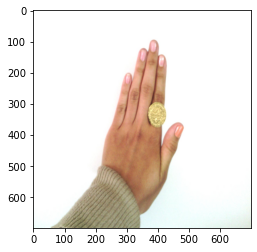

In [230]:
i = 2
org_path = './sangyang/org'
img_info = os.listdir(org_path)
img_path = org_path + '/' + img_info[i]
names = img_info[i].split('_')
img_id = names[1].split('.')[0]
im1 = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
im_rgb = cv2.cvtColor(im1, cv2.COLOR_BGR2RGB)
#get_img_distn(im_rgb, 'red')
plt.imshow(im_rgb)

In [239]:
#(img[:,:,0] -255).max(axis = 0).argmax()
int(np.mean( [ (im_rgb[:,:,i] -255).max(axis = 1).argmax() for i in range(3)]))


93

In [232]:
margin_finder(im_rgb)

(-5, 60, 88)

In [248]:
(im_rgb[:,:,0]).min(axis = 0)

array([237, 234, 234, 234, 237, 237, 237, 239, 239, 239, 241, 239, 239,
       241, 238, 239, 238, 238, 238, 238, 239, 241, 238, 241, 242, 239,
       236, 236, 234, 234, 237, 243, 241, 241, 240, 234, 237, 238, 239,
       241, 244, 243, 243, 243, 243, 241, 244, 244, 244, 242, 244, 244,
       243, 240, 240, 232, 222, 211, 197, 190, 187, 189, 189, 188, 187,
       188, 186, 188, 180, 178, 180, 177, 184, 181, 176, 184, 191, 187,
       183, 177, 170, 171, 170, 160, 157, 125,  95, 113, 101, 110,  97,
        90, 108, 150, 171, 165, 139, 142, 143, 143, 140, 136, 138, 144,
       139, 131, 129, 123, 128, 111, 104, 102, 101, 104, 106, 103, 122,
        98, 109, 114, 106,  94,  88,  85,  79,  75,  92,  95, 102,  99,
        83,  98,  92,  94,  84,  91,  90,  94,  99, 102,  93,  89,  77,
        95,  91,  91,  97,  95,  81,  80,  86,  92,  90,  86,  82,  77,
        88,  93,  89,  92,  93,  95,  99,  93,  93,  74,  82, 102,  96,
        97,  86,  98, 107,  95, 103,  98,  88,  86, 106,  95,  8

In [240]:
int(np.mean( [ (im_rgb[:,:,i] -255).max(axis = 0).argmax() for i in range(3)]))

0

ValueError: zero-size array to reduction operation minimum which has no identity

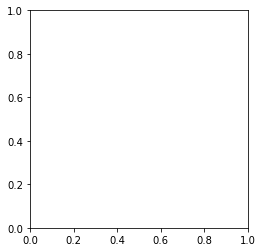

In [231]:
plt.imshow(img_crop(im_rgb, margin_finder(im_rgb)))

In [221]:
def margin_finder(img):
    # input must be rgb immage
    #width, height = img.shape[:2]
    left_margin = int(np.mean( [ (img[:,:,i] -255).max(axis = 0).argmax() for i in range(3)])) 
    up_margin = int(np.mean( [ (img[:,:,i] -255).max(axis = 1).argmax() for i in range(3)])) 
    
    r = (img[:,:,0]).min(axis = 0)
    g = (img[:,:,1]).min(axis = 0)
    b = (img[:,:,2]).min(axis = 0)
    right_margin =5 + min(np.where( ((r >= 200) & (r<235)  & (g>=238) & (g<250) & (b >= 225) & (b < 250)))[0])
    return left_margin, right_margin, up_margin

def img_crop(img, margin):
    left_margin, right_margin, up_margin = margin
    return (img[ up_margin:, left_margin:right_margin, :])

In [ ]:
def scaling_image(org_path, json_data, save_name, save_path, dim_list):

    img_info = os.listdir(org_path)
    # acup info
    acu_info = list(json_data)[0].split('_')[0]
    # directory for saving image
    save_directory = save_path + '/' + save_name
    if not(isdir(save_directory)):
        makedirs(save_directory)
    
    img_directory = save_directory + '/' + save_name 
    if not(isdir(img_directory)):
        makedirs(img_directory)
    # json_file
    json_new = dict()
    
    
    x_offset = [0, 80, 160, 240]
    # x_offset = [0, 20, 40, 60, 80, 100, 120, 140, 160, 180]

    for i in range(0, len(images_info)):
        img_path = org_path + '/' + img_info[i]
        names = img_info[i].split('_')
        img_id = names[1]
        chg_id = names[2].split('.')[0]
        
        # json tag
        acupuncture_id = f"{acu_info}_{img_id}_{chg_id}"
        acupuncture_new_id = acupuncture_id + '_'+save_name
        xy = json_data[acupuncture_id][1]['acup_coord']
        img_hand_pos =  json_data[acupuncture_id][0]['hand_pos']
        
        
        
        
        img = cv2.resize(cv2.imread(img_path, cv2.IMREAD_UNCHANGED), dsize=(dim,dim))
        img_id = ((img_path.split('/')[-1]).split('_')[-1]).split('.')[0]
        height, width = img.shape[:2]
        
        blank_image = np.zeros((700,700,3), np.uint8)
        blank_image[:,:] = (255,255,255)
        l_img = blank_image.copy()
        
        for xmove in x_offset:
            if dim + xmove < 700:
                for row in range(len(img)):
                    for col in range(len(img)):
                        l_img[row, col+xmove] = img[row, col]
                        
                acupuncture_id = f"{acupuncture_info}_{img_id}"
                acupuncture_new_id = acupuncture_id + f'_sc{dim}_tr{xmove}'
                x, y, xy = json_data[acupuncture_id][1].values()
                new_x, new_y = x * dim / 700 + xmove, y * dim / 700
                new_xy = (new_x, new_y)

                json_data[acupuncture_new_id] = list()
                json_data[acupuncture_new_id].append({
                    "acup_info": f"{acupuncture_info}",
                    "hand_pos": f"{img_hand_pos}",
                    "acup_size": f"{acupuncture_size}"
                })
                json_data[acupuncture_new_id].append({
                    "acup_coord_x": new_x,
                    "acup_coord_y": new_y,
                    "acup_coord": new_xy
                })

                cv2.imwrite(f'./{save_directory}/{acupuncture_new_id}.png', l_img)
                l_img = blank_image.copy()
    save_json_file(json_data)

In [ ]:
def translate_image(images_info, json_data, xmove):

    save_directory = f'./{acupuncture_info}/_translated'
    if not(isdir(save_directory)):
        makedirs(save_directory)

    for i in range(0, len(images_info)):
        img_path = images_info[i][0]
        img_hand_pos = images_info[i][1]
        img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
        img_id = ((img_path.split('/')[-1]).split('_')[-1]).split('.')[0]
        rows,cols = img.shape[:2]

        # translate x-axis and y-axis of the image
        M = np.float32([[1,0,xmove],[0,1,0]])
        dst = cv2.warpAffine(img, M, (cols,rows))
        
        if xmove > 0:
            for row in range(len(dst)):
                for col in range(xmove):
                    if np.array_equal(dst[row,col], np.array([0,0,0])):
                        dst[row,col] = np.array([255,255,255])
        else:
            for row in range(len(dst)):
                for col in range(len(dst[row])-1,len(dst[row])+xmove-1,-1):
                    if np.array_equal(dst[row,col], np.array([0,0,0])):
                        dst[row,col] = np.array([255,255,255])
            j

        acupuncture_id = f"{acupuncture_info}_{img_id}"
        x, y, xy = json_data[acupuncture_id][1].values()
        
        acupuncture_new_id = acupuncture_id + f'_tr{xmove}' if xmove >= 0 else acupuncture_id + f'_tr{xmove}'
        
        json_data[acupuncture_new_id] = list()
        json_data[acupuncture_new_id].append({
            "acup_info": f"{acupuncture_info}",
            "hand_pos": f"{img_hand_pos}",
            "acup_size": f"{acupuncture_size}"
        })
        json_data[acupuncture_new_id].append({
            "acup_coord_x": x + xmove,
            "acup_coord_y": y,
            "acup_coord": (x + xmove, y)
        })
        
        cv2.imwrite('./{0}/{1}.png'.format(save_directory, acupuncture_new_id), dst)
        

    save_json_file(json_data)



In [80]:
def rotate_image_trnsfm(org_path, json_data, save_name, save_path, angle_list):
    
    img_info = os.listdir(org_path)
    acu_info = list(json_data)[0].split('_')[0]
    
    save_directory = save_path + '/' + save_name
    if not(isdir(save_directory)):
        makedirs(save_directory)

    img_directory = save_directory + '/' + save_name 
    if not(isdir(img_directory)):
        makedirs(img_directory)
    # json_file
    json_new = dict()
        
    for i in range(0, len(img_info)):
        img_path = org_path + '/' + img_info[i]
        img_id = img_info[i].split('_')[-1].split('.')[0]
        angle = angle_list[i]
            
        # json tag
        acupuncture_id = f"{acu_info}_{img_id}"
        acupuncture_new_id = acupuncture_id + f'_rt{angle}'
        x, y, xy = json_data[acupuncture_id][1].values()
        img_hand_pos =  json_data[acupuncture_id][0]['hand_pos']
        
        # read the image file, then generate rotated image
        img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
        rotated_img = rotate_bound(img, angle)

        # height and width for images
        height, width = img.shape[:2]
        (cx, cy) = (width // 2, height // 2)
        (new_height, new_width) = rotated_img.shape[:2]
        (new_cx, new_cy) = (new_width // 2, new_height // 2)
        
        new_x, new_y = rotate_box((x, y), cx, cy, height, width, angle)
        
        # change to 700 x 700 
        new_x, new_y = int(new_x * 700 / new_width ), int(new_y * 700 / new_height )
        new_xy = (new_x, new_y)
        

        json_new[acupuncture_new_id] = list()
        json_new[acupuncture_new_id].append({
            "acup_info": f"{acupuncture_info}",
            "hand_pos": f"{img_hand_pos}"
        })
        json_new[acupuncture_new_id].append({
            "acup_coord": new_xy
        })
        
        im_mask1 = 255 * (rotated_img == 0)
        rotated_img = (im_mask1 + rotated_img).astype('uint8')
        # resize to 700 x 700
        rotated_img = cv2.resize( rotated_img , dsize=(700,700)) 
        
        cv2.imwrite(f'./{img_directory}/{acupuncture_new_id}.png', rotated_img)

    save_json_file2(json_new, save_directory + '/' + acu_info + '_' + save_name + '.json')

In [81]:
import os
org_path = './sangyang/org'
json_data = open_json_file('./sangyang/sangyang_info.json')
save_name = 'rotated'
save_path = './sangyang'
angle_list = np.random.randint(low = -180, high = 180, size = 3)
rotate_image_trnsfm(org_path, json_data, save_name, save_path, angle_list)

In [38]:
org_path = './sangyang/rotated/rotated'
img_info = os.listdir(org_path)
json_data = open_json_file('./sangyang/rotated/sangyang_rotated.json')
save_name = 'rotated_filled'
save_path = './sangyang/'
fill_background_image2( org_path, json_data, save_name, save_path, imlist)

completed 0 images


In [250]:
dir1 = './background-images/'
imdirs = os.listdir(dir1)
imlist = [ plt.imread(dir1 + i) for i in imdirs ]

testing images


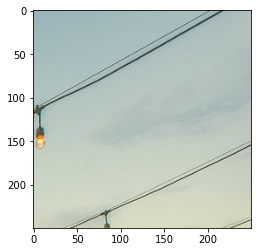

In [2]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

dir1 = './background-images/'
imdirs = os.listdir(dir1)
imlist = [ plt.imread(dir1 + i) for i in imdirs ]

def rand_crop_img (img, size = 250, change_col = True, *args):
    '''
    gets nd array greater than (256x256) as an input
    returns randomly cropped image (256x256) as an output
    channel values are uint of 0 to 255
    '''
    if img.dtype == 'float32':
        img = (img * 255 / np.max(img)).astype('uint8')
    im_pil = Image.fromarray(img.astype('uint8'), 'RGB')

    x_c = np.random.randint(0, im_pil.size[0] - size)
    y_c = np.random.randint(0, im_pil.size[1] - size)
    img_cropped = im_pil.crop((x_c, y_c, x_c + size, y_c + size)) 
    img_cropped = np.asarray(img_cropped) / 255.0

    if change_col == True:
        # change color distn 
        for j in range(3):
            img_cropped[:, :, j] = (img_cropped[:, :, j] + np.random.uniform(0, 0.25) ) / 2.0
            img_cropped = img_cropped / np.max(img_cropped)

    return img_cropped

random_indx = np.random.randint(low = 1,high = 5, size = len(imlist))
print('testing images')
plt.imshow(rand_crop_img(imlist[random_indx[0]]))

In [33]:
def img_from_mask2(img, mask ):
    '''
    mask : 2d array of true/false
    img : 3d array with rgb channels
    '''
    r = img[:,:,0] + 255*mask[:,:,0] 
    g = img[:,:,1] + 255*mask[:,:,1]  
    b = img[:,:,2] + 255*mask[:,:,2]  
    rgb = np.dstack((r,g,b))
    rgb[rgb > 255] = 0
    return rgb


def save_json_file2(json_data, json_file):
    with open(json_file, 'w') as outfile:
        json.dump(json_data, outfile, indent='\t')

def fill_background_image2(org_path, json_data, save_name, save_path, imlist):
    '''
    img_info : list of image names (os.listdir) in the original path 
    '''
    img_info = os.listdir(org_path)
    # acup info
    acu_info = list(json_data)[0].split('_')[0]
    # directory for saving image
    save_directory = save_path + '/' + save_name
    if not(isdir(save_directory)):
        makedirs(save_directory)
    
    img_directory = save_directory + '/' + save_name 
    if not(isdir(img_directory)):
        makedirs(img_directory)
    # json_file
    json_new = dict()
    
    # random index
    random_indx = np.random.randint(low = 0,high = 4, size = len(img_info))
    
    for i in range(0, len(img_info)):
        img_path = org_path + '/' + img_info[i]
        #img_id = img_info[i].split('_')[-1].split('.')[0]
        #img_id = name_list[1]
        names = img_info[i].split('_')
        img_id = names[1]
        chg_id = names[2].split('.')[0]

        # json tag
        acupuncture_id = f"{acu_info}_{img_id}_{chg_id}"
        acupuncture_new_id = acupuncture_id + '_'+save_name
        xy = json_data[acupuncture_id][1]['acup_coord']
        img_hand_pos =  json_data[acupuncture_id][0]['hand_pos']
        
        json_new[acupuncture_new_id] = list()
        json_new[acupuncture_new_id].append({
            "acup_info": f"{acu_info}",
            "hand_pos": f"{img_hand_pos}"
        })
        json_new[acupuncture_new_id].append({
            "acup_coord": xy
        })
        
        # read the image file, then generate image
        img = clear_background(cv2.imread(img_path, cv2.IMREAD_UNCHANGED))
        height, width = img.shape[:2]
        im_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # np format

        # get img mask
        im_mask1 = 1* (im_rgb != 255)
        im_mask2 = 1* (im_rgb == 255)
        
        npimg = rand_crop_img( imlist[ random_indx[i]])
        uint_img = (npimg * 255 / np.max(npimg)).astype('uint8')
        b_image = cv2.resize( uint_img , dsize=(height,width)) 
        
        new_img = img_from_mask2( b_image, im_mask1 ) +  img_from_mask2( im_rgb, im_mask2 )
        # get PIL img
        img_pil = Image.fromarray(new_img.astype('uint8'), 'RGB')   
        img_pil.save(img_directory + '/' + acupuncture_new_id + '.png')
        
        if i % 10 == 0:
            print('completed ' + str(i) + ' images')
    save_json_file2(json_new, save_directory + '/' + acu_info + '_' + save_name + '.json')

In [98]:
def get_img_distn (img, kw='orange'):
    '''
    W x H x C ; C: RGB
    '''
    if kw == 'orange':
        _ = plt.hist(img.ravel(), bins = 256, color = 'orange', )
    
    if kw == 'red':
        _ = plt.hist(img[:, :, 0].ravel(), bins = 256, color = 'red', alpha = 0.5)

    if kw == 'green':
        _ = plt.hist(img[:, :, 1].ravel(), bins = 256, color = 'Green', alpha = 0.5)
    
    if kw == 'blue':
        _ = plt.hist(img[:, :, 2].ravel(), bins = 256, color = 'Blue', alpha = 0.5)

    # _ = plt.xlabel('Intensity Value')
    # _ = plt.ylabel('Count')
    # _ = plt.legend(['Total', 'Red_Channel', 'Green_Channel', 'Blue_Channel'])
    plt.show()